In [193]:
%tensorflow_version 2.x
import tensorflow as tf

# Check for Colab Pro resources
def check_colab_resources():
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    from psutil import virtual_memory
    ram_gb = virtual_memory().total / 1e9
    print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))
    if ram_gb < 20:
        print('Not using a high-RAM runtime.')
    else:
        print('Using a high-RAM runtime.')

check_colab_resources()

Thu Dec  9 18:42:36 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    36W / 250W |   1601MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [194]:
random_seed = 20211205

# Use the "mini" training set with 9 images.
# fcd_ts_dir = '/content/drive/My Drive/PredatorEye/mini_training_set/'
# Use the "real" training set with 2008 images
fcd_ts_dir = '/content/drive/My Drive/PredatorEye/fcd_training_set/'

# max_input_images = 10
max_input_images = 100
# max_input_images = 200
# max_input_images = 300
# max_input_images = 500
# max_input_images = 1000
# max_input_images = 'all' ########################################################## 20211208

# Maybe read from image file?
# Maybe assert all images are square and this size?
fcd_image_size = 1024

# Disk diameter, relative to full sized megapixel image.
disk_size = 201

# For scaling down the input image size.
# input_scale = 1
input_scale = 0.125
# input_scale = 0.25
# input_scale = 0.5
if (input_scale != 1):
    fcd_image_size = int(fcd_image_size * input_scale)
    disk_size = int(disk_size * input_scale)

# Enable prototype code for amplifying the FCD dataset using mirror and rotation
# amplification = False
amplification = True

fcd_epochs = 100
fcd_batch_size = 32

In [195]:
import PIL
import numpy as np
from PIL import Image
from os import listdir
from os.path import join
from numpy import asarray
from matplotlib import image
import matplotlib.pyplot as plt

# from DLAVA, includes unused symbols, maybe tighten later
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

# # trying to get around memory limits:
# from random import sample
import random

# 20211128 temp?
from tensorflow.keras import backend as keras_backend
keras_backend.set_image_data_format('channels_last')

# Progress bar utility
from tqdm.auto import tqdm

import time

In [196]:
#####################
####  Utilities  ####
#####################

# Prints "expression = <value>"
def debug_print(expression):
    print(expression, '=', eval(expression))

# Reset random sequence seeds in Python's "random", Numpy, and TensorFlow.
def reset_random_seeds():
    random.seed(random_seed)
    np.random.seed(random_seed)
    tf.random.set_seed(random_seed)

# Parse FCD filename to a list of two ints: (x, y) pixel coordinates.
def fcd_filename_to_xy_ints(filename):
    without_extension = filename.split('.')[0]
    two_numeric_strings = without_extension.split('_')[1:3]
    return list(map(int, two_numeric_strings))

# Get image label from image file names ([x, y] as floats on [0,1])
def fcd_normalized_xy(filename, pixels):
    pixel_coordinates = fcd_filename_to_xy_pair(filename)
    return pixel_coordinates / (np.array(pixels.shape)[1:2] / input_scale)

# Draw a training image on the log. First arg is either a 24 bit RGB pixel
# representation as read from file, or the rescaled 3xfloat used internally.
# Optionally draw crosshairs to show center of disk.
def draw_image(rgb_pixel_tensor, center=(0,0)):
    i24bit = []
    if (rgb_pixel_tensor.dtype == np.double):
        unscaled_pixels = np.interp(rgb_pixel_tensor, [0, 1], [0, 255])
        i24bit = Image.fromarray(unscaled_pixels.astype('uint8'), mode='RGB')
    else:
        i24bit = Image.fromarray(rgb_pixel_tensor)
    plt.imshow(i24bit)
    if (center != (0,0)):
        draw_crosshairs(center)
    plt.show()

# Draw crosshairs to indicate disk position (label or estimate).
def draw_crosshairs(center):
    m = fcd_image_size - 1   # max image coordinate
    s = disk_size * 1.2 / 2  # gap size (radius)
    h = center[0] * m        # center x in pixels
    v = center[1] * m        # center y in pixels
    plt.hlines(v, 0, max(0, h - s), color="black")
    plt.hlines(v, min(m, h + s), m, color="black")
    plt.vlines(h, 0, max(0, v - s), color="white")
    plt.vlines(h, min(m, v + s), m, color="white")

# Draw line in plot between arbitrary points in plot.
# eg: draw_line((100, 100), (924, 924), color="yellow")
def draw_line(p1, p2, color="white"):
    plt.plot([p1[0], p2[0]], [p1[1], p2[1]], color)

# print(fcd_filename_to_xy_pair("foobar_123_456"))
# debug_print('fcd_normalized_xy("foobar_123_456", np.zeros((1024,1024,3)))')
# debug_print('[123/(1024/input_scale), 456/(1024/input_scale)]')

In [197]:
# Loads FCD training data image files from "directory_pathname". Returns an
# array of images and an array of labels (each an XY pair, the relative position
# of the disk center). Optional "image_count" can to limit the number of images
# read, by taking a random sample of availble image files, defaults to "all".

def read_fcd_data_from_directory(directory_pathname, image_count = 'all'):
    directory_contents = listdir(directory_pathname)
    if (image_count == 'all'): image_count = len(directory_contents)
    assert image_count <= len(directory_contents), "Too few images in directory"
    directory_contents = random.sample(directory_contents, image_count)
    ###
    amp_factor = 1
    if (amplification):
        # amp_factor = 8
        amp_factor = 3
        image_count *= amp_factor # for rot/mir
    ###
    local_images = np.zeros([image_count, fcd_image_size, fcd_image_size, 3])
    local_labels = np.zeros([image_count, 2])
    image_index = 0
    for filename in tqdm(directory_contents):
        image_pathname = join(directory_pathname, filename)
        # Numpy pixel array of image object.
        image = Image.open(image_pathname)
        pixels = asarray(image.resize((fcd_image_size, fcd_image_size),
                                      PIL.Image.LANCZOS))
        # Convert input image data to floating-point.
        float_pixels = keras_backend.cast_to_floatx(pixels)
        # Scale input image data to range [0, 1] (in DLAVA was [-1, 1])
        scaled_pixels = np.interp(float_pixels, [0, 255], [0, 1])
        # Read disk center position from file name.
        center_position = fcd_normalized_xy(filename, pixels)
        ########################################################################
        # draw_image(pixels, center_position)
        # draw_image(scaled_pixels, center_position)
        ########################################################################
        # Progress report
        # image_index += 1
        # if ((image_index % 50) == 0):
        # draw_frequency = 50
        # if ((image_index % draw_frequency) == draw_frequency - 1):
        #     # show_image_from_rgb_pixel_tensor(pixels)
        #     # show_image_from_rgb_pixel_tensor(pixels, center_position)
        #     draw_image(pixels, center_position)
        #     print(image_index, "images...")
        def center_rot90(cp): return (cp[1], 0.5 - (cp[0] - 0.5))
        def center_flip(cp): return (0.5 - (cp[0] - 0.5), cp[1])
        if (amplification):
            variations = 8
            keepers = random.sample(range(1, variations), 2)
            keepers.append(0)
            for i in range(variations):
                # draw_image(pixels, center_position)
                # draw_image(scaled_pixels, center_position)

                # # Copy this pixel data into slice "image_index" of "local_images"
                # local_images[image_index, :, :, :] = scaled_pixels
                # # Copy disk center XY position into slice of "local_labels".
                # # center_position = fcd_normalized_xy(filename, pixels)
                # local_labels[image_index, :] = center_position

                # image_index += 1

                if (keepers.count(i) > 0):
                    # Copy this pixel data into slice "image_index" of "local_images"
                    local_images[image_index, :, :, :] = scaled_pixels
                    # Copy disk center XY position into slice of "local_labels".
                    local_labels[image_index, :] = center_position
                    image_index += 1

                    # draw_image(scaled_pixels, center_position)
                    draw_frequency = 50 * amp_factor
                    if ((image_index % draw_frequency) == draw_frequency - 1):
                        draw_image(scaled_pixels, center_position)
                        print(image_index + 1, "of", image_count, "images...")


                if (i < 7):
                    if (i == 3):
                        scaled_pixels = np.flip(scaled_pixels, axis=1)
                        center_position = center_flip(center_position)
                    else:
                        scaled_pixels = np.rot90(scaled_pixels, k=1, axes=(0, 1))
                        center_position = center_rot90(center_position)
        else:
            local_images[image_index, :, :, :] = scaled_pixels
            local_labels[image_index, :] = center_position
            image_index += 1
    return local_images, local_labels

In [198]:
############################### SANDBOX ###############################

# from https://keras.io/api/losses/regression_losses/

y_true = [[0., 1.], [0., 0.]]
y_pred = [[1., 1.], [1., 0.]]
# Using 'auto'/'sum_over_batch_size' reduction type.
mse = tf.keras.losses.MeanSquaredError()
debug_print('mse(y_true, y_pred).numpy()')

y_true = np.random.randint(0, 2, size=(2, 3))
y_pred = np.random.random(size=(2, 3))
loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
assert loss.shape == (2,)
assert np.array_equal(loss.numpy(), np.mean(np.square(y_true - y_pred), axis=-1))
debug_print('loss.numpy()')


mse(y_true, y_pred).numpy() = 0.5
loss.numpy() = [0.19398712 0.71420236]


In [199]:
############################### SANDBOX ###############################

# WIP custom loss

# import keras.backend as K
import keras.backend as k
import math


# a = np.array([[1, 2], [3, 4], [5, 6]])
# b = np.array([[6, 5], [4, 3], [2, 1]])

# debug_print('math.sqrt(5)')
# debug_print('math.sqrt((1 - 6)**2 + (2 - 5)**2)')
# debug_print('a')
# debug_print('b')
# debug_print('a - b')
# debug_print('k.square(a - b)')
# # dist = np.sqrt(((a[:, None] - b[:, :, None]) ** 2).sum(0))
# # dist = np.sqrt(((a[:, :, None] - b[:, :, None]) ** 2).sum(0))
# dist = np.sqrt(((a[:, None] - b[:, None]) ** 2).sum(0))
# debug_print('dist')

# from scipy.spatial.distance import cdist
# dist = cdist(a, b)
# debug_print('dist')


# def my_distance(x,y):
#     x=np.array(x)
#     y=np.array(y)
#     p=np.sum((x-y)**2)
#     d=np.sqrt(p)
#     return d

# debug_print('my_distance(a, b)')

# a = np.array([[1, 2],
#               [3, 4],
#               [5, 6]])
# b = np.array([[6, 5],
#               [4, 3],
#               [2, 1]])
a = np.array([[1.0, 2.0],
              [3.0, 4.0],
              [5.0, 6.0]])
b = np.array([[6.0, 5.0],
              [4.0, 3.0],
              [2.0, 1.0]])
print('a')
print(a)
print('b')
print(b)
print('a[:,0] and a[:,1]')
print(a[:,0])
print(a[:,1])
print('b[:,0] and b[:,1]')
print(b[:,0])
print(b[:,1])

ax = a[:,0]
ay = a[:,1]
bx = b[:,0]
by = b[:,1]

debug_print('ax')
debug_print('ay')
debug_print('bx')
debug_print('by')

debug_print('ax - bx')
debug_print('ay - by')
debug_print('np.square(ax - bx)')

# distances = np.sqrt(np.square(ax - bx) + np.square(ay - by))
# debug_print('distances')
debug_print('np.sqrt(np.square(ax - bx) + np.square(ay - by))')

debug_print('np.sqrt(np.square(a[:,0] - b[:,0]) + np.square(a[:,1] - b[:,1]))')

debug_print('math.sqrt((1 - 6)**2 + (2 - 5)**2)')


@tf.function
def my_loss(y_true, y_pred):
    print('top of my_loss()')

    # Given 2 [n, 2] arrays, interpreted as two lists of corresponding points
    # in 2d space. Returns an array [n] of Euclidean distances between points.
    def distances(a, b):
        ax = a[:,0]  # x coordinates of a
        ay = a[:,1]  # y coordinates of a
        bx = b[:,0]  # x coordinates of b
        by = b[:,1]  # y coordinates of b
        # return np.sqrt(np.square(ax - bx) + np.square(ay - by))
        return tf.sqrt(tf.square(ax - bx) + tf.square(ay - by))
        # return np.sqrt(np.square(ax - bx) + np.square(ay - by))

    d = distances(y_true, y_pred)
    print('d =', d)

    # print(np.concatenate((d, d), axis=1))
    # q = np.array([d, d])
    # q = tf.convert_to_tensor(np.array([d, d]))
    # q = tf.array([d, d])
    # q = tf.Tensor([d, d])
    # q = tf.constant([d, d])
    # q = [d, d]
    q = np.array([d, d])

    # print(q)
    # print(q.reshape((3, 2)))
    # print(q.reshape((2, 3)))
    # print(np.reshape(q, 6, order='F'))
    # print(np.reshape(q, 6, order='F').reshape((3, 2)))
    # print(np.reshape(q, 6, order='F').reshape((2, 3)))
     
    # # calculating squared difference between target and predicted values 
    # loss = k.square(y_pred - y_true)  # (batch_size, 2)

    # loss = np.reshape(q, 6, order='F').reshape((3, 2))
    batch_size = y_true.shape[0]
    # loss = np.reshape(q, batch_size * 2, order='F').reshape((batch_size, 2))
    # loss = tf.reshape(q, batch_size * 2, order='F').reshape((batch_size, 2))
    # loss = tf.reshape(q, batch_size * 2, order='F').reshape((batch_size, 2))
    # loss = tf.reshape(q, batch_size * 2).reshape((batch_size, 2))
    loss = np.reshape(q, batch_size * 2, order='F').reshape((batch_size, 2))
    loss = tf.convert_to_tensor(loss)
    print(loss)
    
    # # multiplying the values with weights along batch dimension
    # # loss = loss * [0.3, 0.7]          # (batch_size, 2)
    # loss = loss * np.array([0.3, 0.7])  # (batch_size, 2)
                
    # summing both loss values along batch dimension 
    loss = k.sum(loss, axis=1)        # (batch_size,)
    
    # print(loss)
    # return loss
    return tf.convert_to_tensor(loss)


@tf.function
def my_metric(y_true, y_pred):
    return my_loss(y_true, y_pred)

# print(my_loss(a, b).numpy())

a
[[1. 2.]
 [3. 4.]
 [5. 6.]]
b
[[6. 5.]
 [4. 3.]
 [2. 1.]]
a[:,0] and a[:,1]
[1. 3. 5.]
[2. 4. 6.]
b[:,0] and b[:,1]
[6. 4. 2.]
[5. 3. 1.]
ax = [1. 3. 5.]
ay = [2. 4. 6.]
bx = [6. 4. 2.]
by = [5. 3. 1.]
ax - bx = [-5. -1.  3.]
ay - by = [-3.  1.  5.]
np.square(ax - bx) = [25.  1.  9.]
np.sqrt(np.square(ax - bx) + np.square(ay - by)) = [5.83095189 1.41421356 5.83095189]
np.sqrt(np.square(a[:,0] - b[:,0]) + np.square(a[:,1] - b[:,1])) = [5.83095189 1.41421356 5.83095189]
math.sqrt((1 - 6)**2 + (2 - 5)**2) = 5.830951894845301


In [200]:
# Construct a striding CNN Keras model (cribbed from DLAVA chapter B3, Listing
# B3-41): currently 2 Conv2D with dropout, then 2 dense, outpu layer is dense
# with just two neurons, to generate an XY position estimate for the disk.

# ##### 20211208 custom loss function
# import tensorflow.keras.utils.CustomObjectScope


def make_striding_cnn_model():
    cnn_act = 'relu'
    dense_act = 'relu'
    output_act = 'linear'
    cnn_dropout = 0.2
    dense_dropout = 0.5  # ala Hinton (2012)

    model = Sequential()

    # ##### 20211208 custom loss function
    # # custom_objects = {"custom_activation": custom_activation}
    # custom_objects = {"my_loss_fn": my_loss_fn}
    # with tf.keras.utils.CustomObjectScope(custom_objects):
    #     # new_model = keras.Model.from_config(config)
    #     model = Sequential().from_config(config)
    
    # 2 CNN layers, 5x5 and 3x3, each striding down to half size. With dropout.
    model.add(Conv2D(64, (5, 5), activation=cnn_act, padding='same',
                     strides=(2, 2), kernel_constraint=MaxNorm(3),
                     input_shape=(fcd_image_size, fcd_image_size, 3)))
    model.add(Dropout(cnn_dropout))
    model.add(Conv2D(32, (3, 3), activation=cnn_act, padding='same', 
                     strides=(2, 2), kernel_constraint=MaxNorm(3)))
    model.add(Dropout(cnn_dropout))
    # Then flatten and 3 dense (fully connected) layers of decreasing size.
    model.add(Flatten())
    model.add(Dense(128, activation=dense_act))
    model.add(Dropout(dense_dropout))
    model.add(Dense(64, activation=dense_act))
    model.add(Dropout(dense_dropout))
    # Output layer is Dense with two neurons for (x, y) of predicted center.
    model.add(Dense(2, activation=output_act))
    #
    # Compile with mean square error loss, adam optimization, tracking accuracy.
    model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])

    ##### 20211208 custom loss function
    # model.compile(loss='my_loss_fn', optimizer='adam', metrics=["accuracy"])

    # ...working toward custom loss, first a custom metric
    #
    # model.add_metric(my_metric, name='my_metric', aggregation='mean')
    #
    # m = my_metric()
    # model.add_metric(m, name='my_metric', aggregation='mean')
    #
    # model.add_metric(np.array(fcd_batch_size, 2), name='my_metric', aggregation='mean')
    #
    # model.add_metric(y_train, name='my_metric', aggregation='mean')
    #
    # m = my_metric(y_train[0:fcd_batch_size, :],
    #               y_train[0:fcd_batch_size, :])
    #
    # m = my_metric(tf.convert_to_tensor(y_train[0:fcd_batch_size, :]),
    #               tf.convert_to_tensor(y_train[0:fcd_batch_size, :]))
    # model.add_metric(m, name='my_metric', aggregation='mean')

    # model.compile(loss='mse', optimizer='adam', metrics=["accuracy", "my_metric"]) ################### 20211208
    return model

In [201]:
# Utility to fit and plot a run, again cribbed from DLAVA chapter B3.
def run_model(model_maker, plot_title):
    model = model_maker()
    #
    print("In run_model():")
    debug_print('X_train.shape')
    debug_print("y_train.shape")
    #
    history = model.fit(X_train, y_train,
                        ###
                        # 20211204 use a little more for training
                        # validation_split=0.25,
                        validation_split=0.2,
                        ###
                        # epochs=100, batch_size=256) ####################
                        # epochs=100, batch_size=10)
                        # epochs=100, batch_size=4)
                        # epochs=100, batch_size=32)
                        epochs=fcd_epochs, batch_size=fcd_batch_size)
    plot_accuracy_and_loss(history, plot_title)
    # return history
    return model, history

# A little utility to draw plots of accuracy and loss.
def plot_accuracy_and_loss(history, plot_title):
    xs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='validation')

    ################### 20211208
    # plt.plot(xs, history.history['my_metric'], label='my_metric')

    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='validation')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    plt.show()

Reading 100 images from /content/drive/My Drive/PredatorEye/fcd_training_set/


  0%|          | 0/100 [00:00<?, ?it/s]

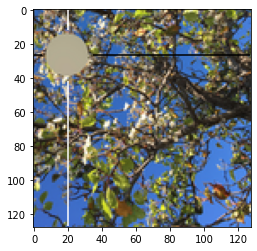

150 of 300 images...


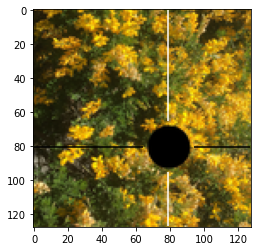

300 of 300 images...
Read 300 training images.
Elapsed time: 4 seconds.


In [202]:
# Read FCD training data from a given directory.
reset_random_seeds()
start_time = time.time()
print('Reading', max_input_images, 'images from ' + fcd_ts_dir)

X_train = []  # Clear these to release the memory early?
y_train = []
X_train, y_train = read_fcd_data_from_directory(fcd_ts_dir, max_input_images)

print('Read', X_train.shape[0], 'training images.')
print('Elapsed time:', int(time.time() - start_time), 'seconds.')

In run_model():
X_train.shape = (300, 128, 128, 3)
y_train.shape = (300, 2)
Epoch 1/100
8/8 [==============================] - 1s 39ms/step - loss: 1.1250 - accuracy: 0.4750 - val_loss: 0.1063 - val_accuracy: 0.4333
Epoch 2/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1600 - accuracy: 0.5208 - val_loss: 0.1036 - val_accuracy: 0.4500
Epoch 3/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1462 - accuracy: 0.4708 - val_loss: 0.1301 - val_accuracy: 0.5500
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1380 - accuracy: 0.4375 - val_loss: 0.1856 - val_accuracy: 0.5500
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1235 - accuracy: 0.4792 - val_loss: 0.1469 - val_accuracy: 0.5500
Epoch 6/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1123 - accuracy: 0.5125 - val_loss: 0.1518 - val_accuracy: 0.5500
Epoch 7/100
8/8 [==============================] - 0s 15ms/step - loss: 0.1101 - acc

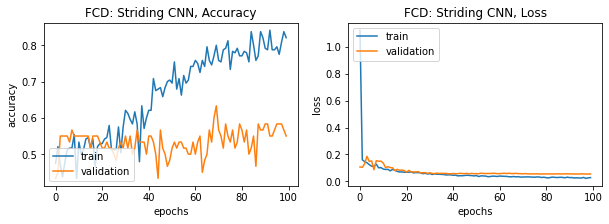

In [203]:
# Run a model.
reset_random_seeds()
model = []  # To release memory when rerunning in notebook?
history = []
(model, history) = run_model(make_striding_cnn_model, 'FCD: Striding CNN')

##### 20211208 custom loss function

Computing predictions...
187 : ( 0.7798677 , 0.42817143 )


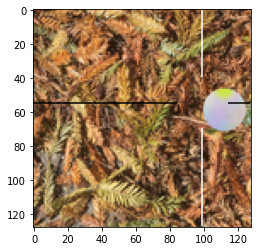

194 : ( 0.34325886 , 0.6242614 )


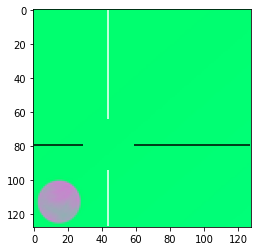

292 : ( 0.331681 , 0.50457704 )


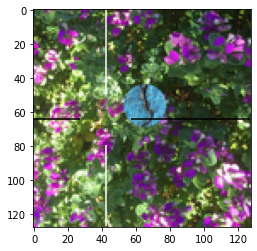

215 : ( 0.46545827 , 0.54924047 )


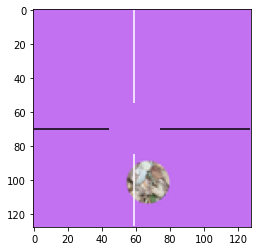

158 : ( 0.75966126 , 0.34205848 )


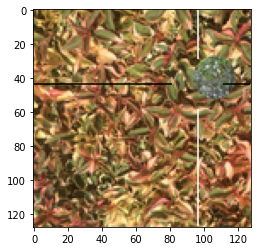

43 : ( 0.40891743 , 0.43504432 )


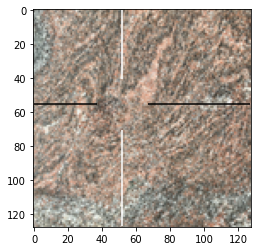

192 : ( 0.5300745 , 0.6562203 )


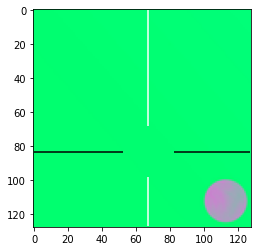

297 : ( 0.4053368 , 0.5507769 )


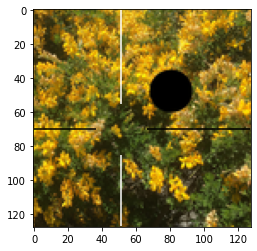

104 : ( 0.50721985 , 0.4826233 )


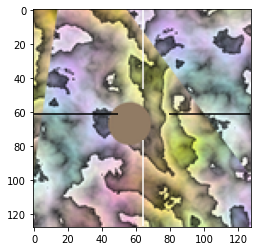

293 : ( 0.49690205 , 0.4118912 )


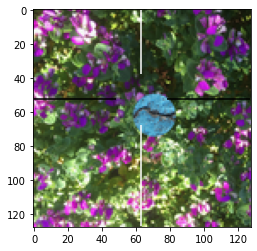

In [204]:
# Draw some results to understand performance

def draw_results():
    print("Computing predictions...")
    predictions = model.predict([X_train])
    for i in range(10):
        index = random.randint(0, X_train.shape[0] - 1)
        p = predictions[index]
        x = p[0]
        y = p[1]
        print(index, ": (", x, ",", y, ")")
        # print(X_train[index, :, :, :].shape)
        draw_image(X_train[index, :, :, :], [x, y])

draw_results()